# Preliminaries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

Import the data

In [4]:
path = "../Datasets/"
Train = pd.read_csv(path + '/Historical-transaction-data.csv')
StoreInfo = pd.read_csv(path + '/Store-info.csv')
Submission_testing = pd.read_csv(path + '/Testing-data.csv')

Join both datasets to form a train dataset

In [5]:
Train = Train.merge(StoreInfo, on='shop_id', how='left')

In [6]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)
# Submission_testing = Submission_testing.merge(StoreInfo, on='shop_id', how='left')
# Submission_testing.drop("shop_profile", axis=1, inplace=True)
Submission_testing = Submission_testing.merge(Train, on='shop_id', how='left')

In [7]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)

In [8]:
Train.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2,678,Moderate
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2,668,Moderate
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2,678,Moderate
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2,678,Moderate
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5,668,Moderate


In [9]:
Submission_testing.head()

,shop_id,item_description,transaction_date,invoice_id,customer_id,item_price,quantity_sold,shop_area_sq_ft
0,SHOP046,FIT O MIXED FRUIT 1L,2021-10-15T00:00:00.000Z,154826.0,H6RV,270,1,545
1,SHOP046,FIT O ORANGE 1L,2021-10-27T00:00:00.000Z,157798.0,Z1SZ,290,1,545
2,SHOP046,LEMONADE 1.5L,2021-10-28T00:00:00.000Z,157881.0,HFM8,220,2,545
3,SHOP046,FIT O MANGO 200ML,2021-11-03T00:00:00.000Z,159352.0,RFTZ,180,4,545
4,SHOP046,FIT O MIXED FRUIT 200ML,2021-11-03T00:00:00.000Z,159352.0,RFTZ,60,1,545


In [10]:
print("New length: ", Train.shape[0])

New length:  473974


Remove Duplicates

In [11]:
i_length = Train.shape[0]

In [12]:
Train.drop_duplicates(inplace=True)

In [13]:

print("Duplicates dropped from Train: ", i_length - Train.shape[0] )
print("New length: ", Train.shape[0])

Duplicates dropped from Train:  31211
New length:  442763


# Analysis

Missing data

<AxesSubplot:>

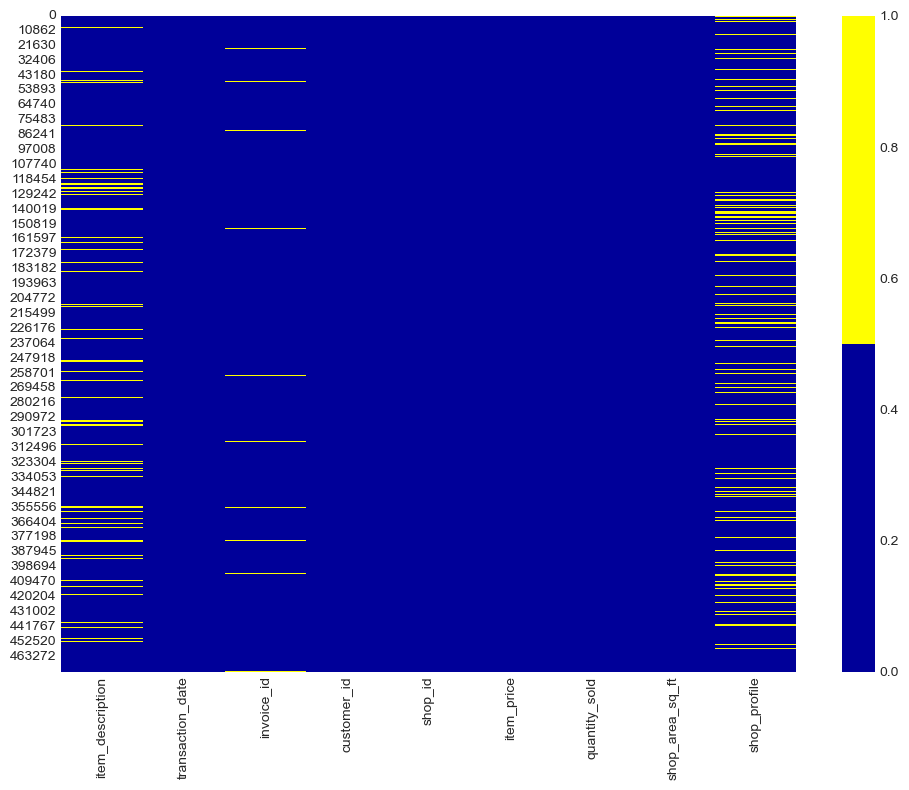

In [14]:
plt.figure(figsize=(10,8))
cols = Train.columns
colours = ['#000099', '#ffff00'] # specify colours: yellow - missing. blue - not missing
sns.heatmap(Train[cols].isna(), cmap=sns.color_palette(colours))

<AxesSubplot:>

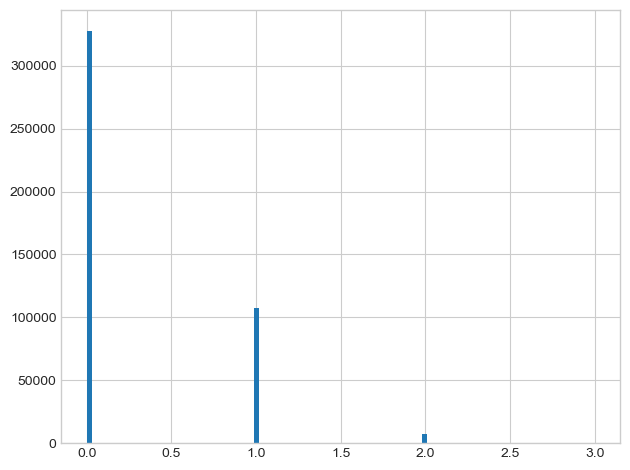

In [15]:
# No. of columns missing for the rows
missing_by_row = Train.isna().sum(axis="columns")
missing_by_row.hist(bins=100)

In [16]:
pct_missing = Train.isna().mean()
pct_missing[:15]

item_description    0.079198
transaction_date    0.000000
invoice_id          0.013030
customer_id         0.000000
shop_id             0.000000
item_price          0.000000
quantity_sold       0.000000
shop_area_sq_ft     0.000000
shop_profile        0.183565
dtype: float64

In [17]:
#Remove rows with null values for item_description or shop_profile
Train = Train.dropna(subset=['item_description', 'shop_profile'], axis=0)

In [18]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332581 entries, 0 to 473973
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_description  332581 non-null  object 
 1   transaction_date  332581 non-null  object 
 2   invoice_id        327971 non-null  float64
 3   customer_id       332581 non-null  object 
 4   shop_id           332581 non-null  object 
 5   item_price        332581 non-null  int64  
 6   quantity_sold     332581 non-null  int64  
 7   shop_area_sq_ft   332581 non-null  int64  
 8   shop_profile      332581 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 25.4+ MB


In [19]:
print("New length: ", Train.shape[0])

New length:  332581


Fill Missing Values

In [20]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332581 entries, 0 to 473973
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_description  332581 non-null  object 
 1   transaction_date  332581 non-null  object 
 2   invoice_id        327971 non-null  float64
 3   customer_id       332581 non-null  object 
 4   shop_id           332581 non-null  object 
 5   item_price        332581 non-null  int64  
 6   quantity_sold     332581 non-null  int64  
 7   shop_area_sq_ft   332581 non-null  int64  
 8   shop_profile      332581 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 25.4+ MB


Encoding

In [21]:
# Set the data types of each feature

# The nominative (unordered) categorical features
features_nom = ["item_description", "customer_id", "shop_id", "shop_profile"]

for feature in features_nom:
    Train[feature] = Train[feature].astype("category")
    if feature == "shop_profile":
        continue
    Submission_testing[feature] = Submission_testing[feature].astype("category")

Train["transaction_date"] = pd.to_datetime(Train["transaction_date"])

In [22]:
Train_y = Train["shop_profile"]
Train.drop("shop_profile", axis=1, inplace=True)

In [23]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332581 entries, 0 to 473973
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   item_description  332581 non-null  category           
 1   transaction_date  332581 non-null  datetime64[ns, UTC]
 2   invoice_id        327971 non-null  float64            
 3   customer_id       332581 non-null  category           
 4   shop_id           332581 non-null  category           
 5   item_price        332581 non-null  int64              
 6   quantity_sold     332581 non-null  int64              
 7   shop_area_sq_ft   332581 non-null  int64              
dtypes: category(3), datetime64[ns, UTC](1), float64(1), int64(3)
memory usage: 22.3 MB


In [24]:
Train.drop(["invoice_id", "customer_id"], axis=1, inplace=True)
Submission_testing.drop(["invoice_id", "customer_id"], axis=1, inplace=True)

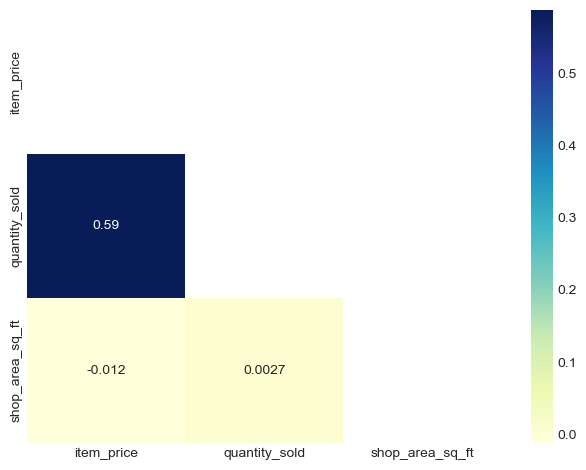

In [25]:
# creating mask
mask = np.triu(np.ones_like(Train.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(Train.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
plt.show()

In [26]:
# Check for outliers

Train.kurt(numeric_only=True)

item_price         382.227475
quantity_sold      420.507197
shop_area_sq_ft      2.908254
dtype: float64

In [27]:
Train["quantity_sold"].describe()

count    332581.000000
mean          1.874626
std           1.539118
min          -1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max         101.000000
Name: quantity_sold, dtype: float64

In [28]:
# TODO : further investigate the outliers

In [29]:
Train["item_price"].describe()

count    332581.000000
mean        214.825306
std         167.916289
min          35.000000
25%         110.000000
50%         220.000000
75%         220.000000
max       17400.000000
Name: item_price, dtype: float64

In [30]:
Train['timestamp_dt'] = pd.to_datetime(Train['transaction_date'], format='%Y-%m-%d')
Train['year'] = Train['timestamp_dt'].dt.year
Train['month'] = Train['timestamp_dt'].dt.month
Train['weekday'] = Train['timestamp_dt'].dt.weekday

Train.drop(['timestamp_dt', 'transaction_date'], axis=1, inplace=True)

Train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,ORANGE BARLEY 1.5L,SHOP008,220,2,678,2021,12,5
1,GINGER BEER 1.5L,SHOP112,220,2,668,2021,10,6
2,TONIC PET 500ML,SHOP008,160,2,678,2021,12,0
3,CREAM SODA 1L,SHOP008,150,2,678,2021,12,0
4,STRAWBERRY MILK 180ML,SHOP112,210,5,668,2021,10,5


In [31]:
Submission_testing['timestamp_dt'] = pd.to_datetime(Submission_testing['transaction_date'], format='%Y-%m-%d')
Submission_testing['year'] = Submission_testing['timestamp_dt'].dt.year
Submission_testing['month'] = Submission_testing['timestamp_dt'].dt.month
Submission_testing['weekday'] = Submission_testing['timestamp_dt'].dt.weekday

Submission_testing.drop(['timestamp_dt', 'transaction_date'], axis=1, inplace=True)

Submission_testing.head()

,shop_id,item_description,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,SHOP046,FIT O MIXED FRUIT 1L,270,1,545,2021,10,4
1,SHOP046,FIT O ORANGE 1L,290,1,545,2021,10,2
2,SHOP046,LEMONADE 1.5L,220,2,545,2021,10,3
3,SHOP046,FIT O MANGO 200ML,180,4,545,2021,11,2
4,SHOP046,FIT O MIXED FRUIT 200ML,60,1,545,2021,11,2


In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Train_y = le.fit_transform(Train_y)

In [33]:
# remove the substring "SHOP" from the shop_id column and convert it to int
Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "").astype(int)
# Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "")
# Train["shop_id"] = Train["shop_id"].astype()")
# convert it to categorical
Train["shop_id"] = Train["shop_id"].astype("category")

In [34]:
# remove the substring "SHOP" from the shop_id column
Submission_testing["shop_id"] = Submission_testing["shop_id"].str.replace("SHOP", "").astype(int)

In [35]:
## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Train, Train_y, test_size = 0.2, random_state = 1)

In [36]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [37]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266064 entries, 13201 to 182378
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   item_description  266064 non-null  category
 1   shop_id           266064 non-null  category
 2   item_price        266064 non-null  int64   
 3   quantity_sold     266064 non-null  int64   
 4   shop_area_sq_ft   266064 non-null  int64   
 5   year              266064 non-null  int64   
 6   month             266064 non-null  int64   
 7   weekday           266064 non-null  int64   
dtypes: category(2), int64(6)
memory usage: 14.7 MB


In [39]:
Submission_testing = Submission_testing[Train.columns]

In [40]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [41]:
# unique values in each column
X_train.nunique()

item_description     37
shop_id             100
item_price          172
quantity_sold        59
shop_area_sq_ft      53
year                  1
month                 3
weekday               7
dtype: int64

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266064 entries, 13201 to 182378
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   item_description  266064 non-null  category
 1   shop_id           266064 non-null  category
 2   item_price        266064 non-null  int64   
 3   quantity_sold     266064 non-null  int64   
 4   shop_area_sq_ft   266064 non-null  int64   
 5   year              266064 non-null  int64   
 6   month             266064 non-null  int64   
 7   weekday           266064 non-null  int64   
dtypes: category(2), int64(6)
memory usage: 14.7 MB


In [43]:
categorical_columns = ["year", "month", "weekday"]

for category in categorical_columns:
    Train[category] = Train[category].astype("category")

# Metrics

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


def score_classification(model, df1_x, df1_y, df2_x, df2_y):
  print(model)
  df1_x = df1_x.copy()
  df2_x = df2_x.copy()
  
  ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')
 
  # One hot encoding for the item_description column

  df1_encoded = ct.fit_transform(df1_x[["item_description"]])
  df1_x = pd.concat([df1_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')
 
  df2_encoded = ct.transform(df2_x[["item_description"]]) 
  df2_x = pd.concat([df2_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')    
  
  df1_x.columns = df1_x.columns.astype(str)
  df2_x.columns = df2_x.columns.astype(str)
 
  # Fit the model  
  model.fit(df1_x, df1_y)

  # Make predictions
  y_pred = model.predict(df2_x)

  # Evaluate the model
  accuracy = accuracy_score(df2_y, y_pred)
  precision = precision_score(df2_y, y_pred,  average='macro')
  recall = recall_score(df2_y, y_pred,  average='macro')
  f1 = f1_score(df2_y, y_pred,  average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

In [45]:
Submission_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86633 entries, 0 to 86632
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   item_description  80319 non-null  category
 1   shop_id           86633 non-null  int32   
 2   item_price        86633 non-null  int64   
 3   quantity_sold     86633 non-null  int64   
 4   shop_area_sq_ft   86633 non-null  int64   
 5   year              86633 non-null  int64   
 6   month             86633 non-null  int64   
 7   weekday           86633 non-null  int64   
dtypes: category(1), int32(1), int64(6)
memory usage: 5.0 MB


## Result Output

In [46]:
def outputResult(model, df1_x, df1_y, test, le):
    print(model)
    df1_x = df1_x.copy()
    df2_x = test.copy()
    
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

    # One hot encoding for the item_description column

    df1_encoded = ct.fit_transform(df1_x[["item_description"]])
    df1_x = pd.concat([df1_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

    df2_encoded = ct.transform(df2_x[["item_description"]])
    df2_x = pd.concat([df2_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

    df1_x.columns = df1_x.columns.astype(str)
    df2_x.columns = df2_x.columns.astype(str)

    # Fit the model on the training data
    model.fit(df1_x, df1_y)
    
    # Make predictions on the test data
    y_pred = model.predict(df2_x)
    
    # Inverse transform the encoded predictions to the original shop profiles
    y_pred = le.inverse_transform(y_pred)    
    
    # Create a dataframe with the predicted shop profiles
    results_df = pd.DataFrame({'shop_id': test.shop_id, 'shop_profile': y_pred})    
    # rename the shop_id column with the word "SHOP" and add a 0 in front of the shop_id
    results_df["shop_id"] = results_df["shop_id"].astype(str)
    results_df["shop_id"] = "SHOP" + results_df["shop_id"].str.zfill(3)
    
    results_df.drop_duplicates(inplace=True)
    # Write the dataframe to a CSV file
    results_df.to_csv('predictions_'+str(model).strip("()")+'.csv', index=False)

# Modelling

In [47]:
# unique values in item_description column

print(X_train['item_description'].unique())

# no of null values in item_description column

print(X_train['item_description'].isnull().sum())

['SODA 1L', 'LEMONADE 500ML', 'LEMONADE 1.5L', 'GINGER BEER 1.5L', 'SODA 500ML', ..., 'GINGER BEER SUGAR FREE 500ML', 'LEMONADE 1L', 'NECTO 1L', 'CHOCOLATE MILK 180ML', 'LIME CRUSH JUICE 1L']
Length: 37
Categories (37, object): ['BOTTLED DRINKING WATER 1.5L', 'BOTTLED DRINKING WATER 500ML', 'CHOCOLATE MILK 180ML', 'CREAM SODA 1.5L', ..., 'SODA PET 1.5L', 'STRAWBERRY MILK 180ML', 'TONIC PET 500ML', 'TWISTEE APPLE 1L']
0


In [48]:
from sklearn.linear_model import LogisticRegression
import sys
logr = LogisticRegression()
# np.set_printoptions(threshold=np.inf)
score_classification(logr, X_train, y_train, X_test, y_test)
# np.set_printoptions(threshold=1000)

LogisticRegression()
Accuracy: 0.4177127651577792
Precision: 0.40657155211397283
Recall: 0.4031049033930501
F1 Score: 0.3961679449191819


Bug with KNeighborsClassifiers

In [49]:
#Dont use this
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier()

# score_classification(knn, X_train, y_train, X_test, y_test)

In [50]:
# outputResult(knn, X_train, y_train, Submission_testing, le)

In [51]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [52]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [53]:
Submission_testing.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,FIT O MIXED FRUIT 1L,46,270,1,545,2021,10,4
1,FIT O ORANGE 1L,46,290,1,545,2021,10,2
2,LEMONADE 1.5L,46,220,2,545,2021,10,3
3,FIT O MANGO 200ML,46,180,4,545,2021,11,2
4,FIT O MIXED FRUIT 200ML,46,60,1,545,2021,11,2


In [54]:
outputResult(dtc, X_train, y_train, Submission_testing, le)

DecisionTreeClassifier()


In [55]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier()
Accuracy: 0.9760662687733963
Precision: 0.9761168100734796
Recall: 0.9753853826851172
F1 Score: 0.97572088280059


In [56]:
outputResult(rfc, X_train, y_train, Submission_testing, le)

RandomForestClassifier()


In [57]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

score_classification(nb, X_train, y_train, X_test, y_test)

GaussianNB()
Accuracy: 0.4189455327209585
Precision: 0.4542690849945639
Recall: 0.40085688663882246
F1 Score: 0.3635349112833701


In [58]:
# import xgboost as xgb

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5)

# score_classification(xgb_model, X_train, y_train, X_test, y_test)


# Feature Engineering

Mutual Information

In [59]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # all discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores


def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width,scores)
  plt.yticks(width, ticks)
  plt.title("Mututal Information Scores")

In [60]:
mi_scores = make_mi_scores(X_train, y_train)
mi_scores

shop_id             1.094757
shop_area_sq_ft     0.579597
year                0.021894
quantity_sold       0.009331
item_price          0.008191
month               0.006593
weekday             0.004389
item_description    0.004223
Name: Mutual Information Scores, dtype: float64

In [61]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


Feature Scaling

In [62]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
13201,SODA 1L,86,110,2,661,2021,10,5
293065,LEMONADE 500ML,37,200,2,717,2021,12,5
63548,LEMONADE 1.5L,66,220,3,470,2021,12,0
466484,GINGER BEER 1.5L,60,220,1,676,2021,10,2
316348,SODA 1L,112,220,3,668,2021,11,0


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

ct2 = ColumnTransformer([("sScaler", StandardScaler(), ["shop_area_sq_ft"]),
                         ("MinMaxScaler", MinMaxScaler(), ["item_price", "quantity_sold"])])
scaled_df1_x = pd.DataFrame(ct2.fit_transform(X_train), columns=["shop_area_sq_ft", "item_price", "quantity_sold"])
scaled_df2_x = pd.DataFrame(ct2.transform(X_test), columns=["shop_area_sq_ft", "item_price", "quantity_sold"])

# Create copies of X_train and X_test with the scaled values
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Assign the scaled values to the new dataframes
X_train_scaled[scaled_df1_x.columns] = scaled_df1_x
X_test_scaled[scaled_df2_x.columns] = scaled_df2_x

In [64]:
X_train.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,SODA 1L,86,110,2,661,2021,10,5
1,LEMONADE 500ML,37,200,2,717,2021,12,5
2,LEMONADE 1.5L,66,220,3,470,2021,12,0
3,GINGER BEER 1.5L,60,220,1,676,2021,10,2
4,SODA 1L,112,220,3,668,2021,11,0


In [65]:
X_test_scaled.head()

,item_description,shop_id,item_price,quantity_sold,shop_area_sq_ft,year,month,weekday
0,GINGER BEER 1L,10,0.006623,0.019608,-0.129331,2021,12,4
1,SODA 500ML,127,0.002016,0.019608,1.726061,2021,10,1
2,GINGER BEER 1.5L,84,0.010654,0.019608,-0.129331,2021,10,1
3,GINGER BEER 1.5L,17,0.010654,0.019608,-0.129331,2021,12,1
4,SODA 1L,83,0.004319,0.029412,0.344557,2021,12,1


In [66]:

print("Scores after standard scaling: ")
score_classification(rfc, X_train_scaled, y_train, X_test_scaled, y_test)

Scores after standard scaling: 
RandomForestClassifier()
Accuracy: 0.9725934723454155
Precision: 0.9726014220383554
Recall: 0.9719298436224828
F1 Score: 0.9722267578441782


In [67]:
score_classification(dtc, X_train_scaled, y_train, X_test_scaled, y_test)

DecisionTreeClassifier()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [68]:
from sklearn.decomposition import PCA

def apply_pca(X):
  pca= PCA()
  df1_x = X.copy()
  ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

  # One hot encoding for the item_description column

  df1_encoded = ct.fit_transform(df1_x[["item_description"]])
  df1_x = pd.concat([df1_x.drop("item_description", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

  df1_x.columns = df1_x.columns.astype(str)

  X_pca = pca.fit_transform(df1_x)
  component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
  X_pca = pd.DataFrame(X_pca, columns=component_names)
  #create loadings
  loadings = pd.DataFrame(
  pca.components_.T,
  columns = component_names,
  index=df1_x.columns,
  )
  return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
  fig, axs = plt.subplots(1,2)
  n = pca.n_components_
  grid = np.arange(1, n+1)
  evr = pca.explained_variance_ratio_
  axs[0].bar(grid,evr)
  axs[0].set(
      xlabel="Component",title="% Explained Variance", ylim=(0.0,1.0)             )
  #Cumulative Variance
  cv = np.cumsum(evr)
  axs[1].plot(np.r_[0,grid], np.r_[0,cv], "o-")
  axs[1].set(xlabel="Component", title="% Cumulatve Variance", ylim=(0.0, 1.0))
  fig.set(figwidth=8, dpi=100)
  return axs

In [69]:
pca, X_pca, loadings = apply_pca(X_train_scaled)
print(loadings)

                          PC1           PC2           PC3           PC4  \
shop_id          9.999996e-01  4.073305e-04  7.770663e-04  1.847195e-05   
item_price       2.802110e-06  7.253940e-07 -1.116153e-04 -4.562880e-04   
quantity_sold    4.081165e-06  6.533448e-05  8.778209e-05 -7.046554e-05   
shop_area_sq_ft -7.745281e-04 -5.647505e-03  9.997760e-01 -1.372293e-02   
year            -0.000000e+00  0.000000e+00 -1.040834e-17  1.110223e-16   
month            3.023641e-05  1.075261e-02 -1.319957e-02 -9.926971e-01   
weekday          4.123251e-04 -9.999185e-01 -5.787727e-03 -1.030803e-02   
0                3.538831e-05  4.065901e-04  2.313522e-04 -3.373090e-04   
1                4.678739e-05  7.371814e-04  5.253566e-03 -7.205063e-04   
2               -3.081842e-07  6.253379e-06 -2.643098e-05 -1.290928e-04   
3               -2.438773e-05 -4.966977e-04 -4.258894e-03 -1.167124e-02   
4               -9.818816e-06 -8.160396e-05  1.024362e-03  1.031647e-04   
5               -4.283437

In [70]:
# create new features
X_train_scaled["total_revenue"] = X_train_scaled["item_price"] * X_train_scaled["quantity_sold"]
X_test_scaled["total_revenue"] = X_test_scaled["item_price"] * X_test_scaled["quantity_sold"]

X_train_scaled.drop(["item_price", "quantity_sold"], axis=1, inplace=True)
X_test_scaled.drop(["item_price", "quantity_sold"], axis=1, inplace=True)

In [71]:
mi_scores = make_mi_scores(X_pca, y_train)
mi_scores

PC1     1.092137
PC3     0.922310
PC2     0.813435
PC4     0.705458
PC20    0.526378
PC5     0.520097
PC10    0.517198
PC8     0.503522
PC18    0.498645
PC23    0.492386
PC14    0.489111
PC28    0.488910
PC33    0.484306
PC22    0.483800
PC17    0.480447
PC13    0.477267
PC35    0.476823
PC19    0.476669
PC15    0.475994
PC24    0.475980
PC42    0.475768
PC6     0.472891
PC36    0.472135
PC7     0.471602
PC21    0.470641
PC11    0.468679
PC16    0.467102
PC9     0.466920
PC31    0.466909
PC29    0.465286
PC30    0.464821
PC12    0.464109
PC37    0.463963
PC38    0.462273
PC26    0.460995
PC39    0.460308
PC41    0.458861
PC40    0.458275
PC34    0.457402
PC27    0.455995
PC32    0.455208
PC25    0.454391
PC43    0.451809
PC44    0.449076
Name: Mutual Information Scores, dtype: float64

In [73]:
# prepare data from model
score_classification(rfc, X_train_scaled, y_train, X_test_scaled, y_test)

RandomForestClassifier()
Accuracy: 0.9844100004510126
Precision: 0.9844297452502767
Recall: 0.983946376473872
F1 Score: 0.9841679944336


In [74]:
score_classification(dtc, X_train_scaled, y_train, X_test_scaled, y_test)

DecisionTreeClassifier()
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
